# Python: Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate local potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier

The data is generated similar to in [Kallus et al.](https://arxiv.org/abs/1912.12945)



In [2]:
def f_loc(D, X):
  loc = 0.3*D + 4*D*X[:,4]*2*X[:,1] - 3*X[:,3]
  return loc

def f_scale(D,X):
  scale = np.sqrt(0.5*D + 3*D*X[:,1] + 1)
  return scale

def dgp(n=200, p=5):
    X = np.random.uniform(0,1,size=[n,p])
    Z = np.random.binomial(1, p=0.5, size=n) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
    D = np.random.binomial(1, p=0.2 * Z + 0.4, size=n)
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X) + f_scale(D, X)*epsilon

    return Y, X, D, Z

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [3]:
tau_vec = np.arange(0.2,0.9,0.1)
tau_vec = [0.3, 0.5, 0.7]
p = 10
n_true = int(10e+6)

In [4]:
X_true = np.random.uniform(0,1,size=[n_true,p])
Z_true = np.random.binomial(1, p=0.5, size=n_true) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
eta_true = np.random.normal(size=n_true)
D1_true = ((0.1*1 + eta_true) > 0)*1.0
D0_true = ((0.1*0 + eta_true) > 0)*1.0
epsilon_true = np.random.normal(size=n_true)

compliers = (D1_true == 1) * (D0_true == 0)
n_compliers = compliers.sum()
Y1 = f_loc(np.ones(n_compliers), X_true[compliers, :]) + f_scale(np.ones(n_compliers), X_true[compliers, :])*epsilon_true[compliers]
Y0 = f_loc(np.zeros(n_compliers), X_true[compliers, :]) + f_scale(np.zeros(n_compliers), X_true[compliers, :])*epsilon_true[compliers]

In [5]:
Y0_quant = np.quantile(Y0, q=tau_vec)
Y1_quant = np.quantile(Y1, q=tau_vec)

print(Y0_quant)
print(Y1_quant)

[-2.22135286 -1.49928545 -0.78048271]
[-0.69677036  0.55845901  1.97762437]


Let us generate $n=500$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [6]:
n = 5000
p = 5
Y, X, D, Z = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D, Z)

Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [7]:
ml_m = RandomForestClassifier(n_estimators=300)
ml_g = RandomForestClassifier(n_estimators=300)

PQ_0 = np.full((len(tau_vec)), np.nan)
PQ_1 = np.full((len(tau_vec)), np.nan)

ci_PQ_0 = np.full((len(tau_vec),2), np.nan)
ci_PQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    dml_PQ_1 = dml.DoubleMLPQ(obj_dml_data,
                              ml_g, ml_m,
                              score="LPQ",
                              treatment=1,
                              n_folds=5,
                              trimming_threshold=0.05)
    dml_PQ_1.fit()

    ci_PQ_1[idx_tau, :] = dml_PQ_1.confint(level=0.95).to_numpy()
    PQ_1[idx_tau] = dml_PQ_1.coef

    dml_PQ_0 = dml.DoubleMLPQ(obj_dml_data,
                              ml_g, ml_m,
                              score="LPQ",
                              treatment=0,
                              n_folds=5,
                              trimming_threshold=0.05)
    dml_PQ_0.fit()

    ci_PQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    PQ_0[idx_tau] = dml_PQ_0.coef

d:\github\doubleml-for-py\doubleml\double_ml_score_mixins.py:210: UserWarning: Could not find a root of the score function. Maximum score value found is 0.9991974266810252 for parameter theta equal to [-1.51758593]. No theta found such that the score function evaluates to a positive value.
  warnings.warn('Could not find a root of the score function. '
d:\github\doubleml-for-py\doubleml\double_ml_score_mixins.py:210: UserWarning: Could not find a root of the score function. Maximum score value found is 0.9820309567205342 for parameter theta equal to [-1.57450821]. No theta found such that the score function evaluates to a positive value.
  warnings.warn('Could not find a root of the score function. '
d:\github\doubleml-for-py\doubleml\double_ml_score_mixins.py:210: UserWarning: Could not find a root of the score function. Maximum score value found is 0.9976703427541419 for parameter theta equal to [-1.49501569]. No theta found such that the score function evaluates to a positive value.

Finally, let us take a look at the estimated quantiles.

In [8]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": PQ_0, "DML Y(1)": PQ_1,
        "DML Y(0) lower": ci_PQ_0[:, 0], "DML Y(0) upper": ci_PQ_0[:, 1],
        "DML Y(1) lower": ci_PQ_1[:, 0], "DML Y(1) upper": ci_PQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

   Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.3 -2.221353 -0.696770 -1.517586  0.575399       -1.959901   
1       0.5 -1.499285  0.558459 -1.574508  0.344416       -2.058307   
2       0.7 -0.780483  1.977624 -1.495016  0.575399       -1.982373   

   DML Y(0) upper  DML Y(1) lower  DML Y(1) upper  
0       -1.075271       -0.089103        1.239901  
1       -1.090710       -0.381132        1.069964  
2       -1.007659       -0.137423        1.288221  


Text(0.02, 0.5, 'Potential Quantile and 95%-CI')

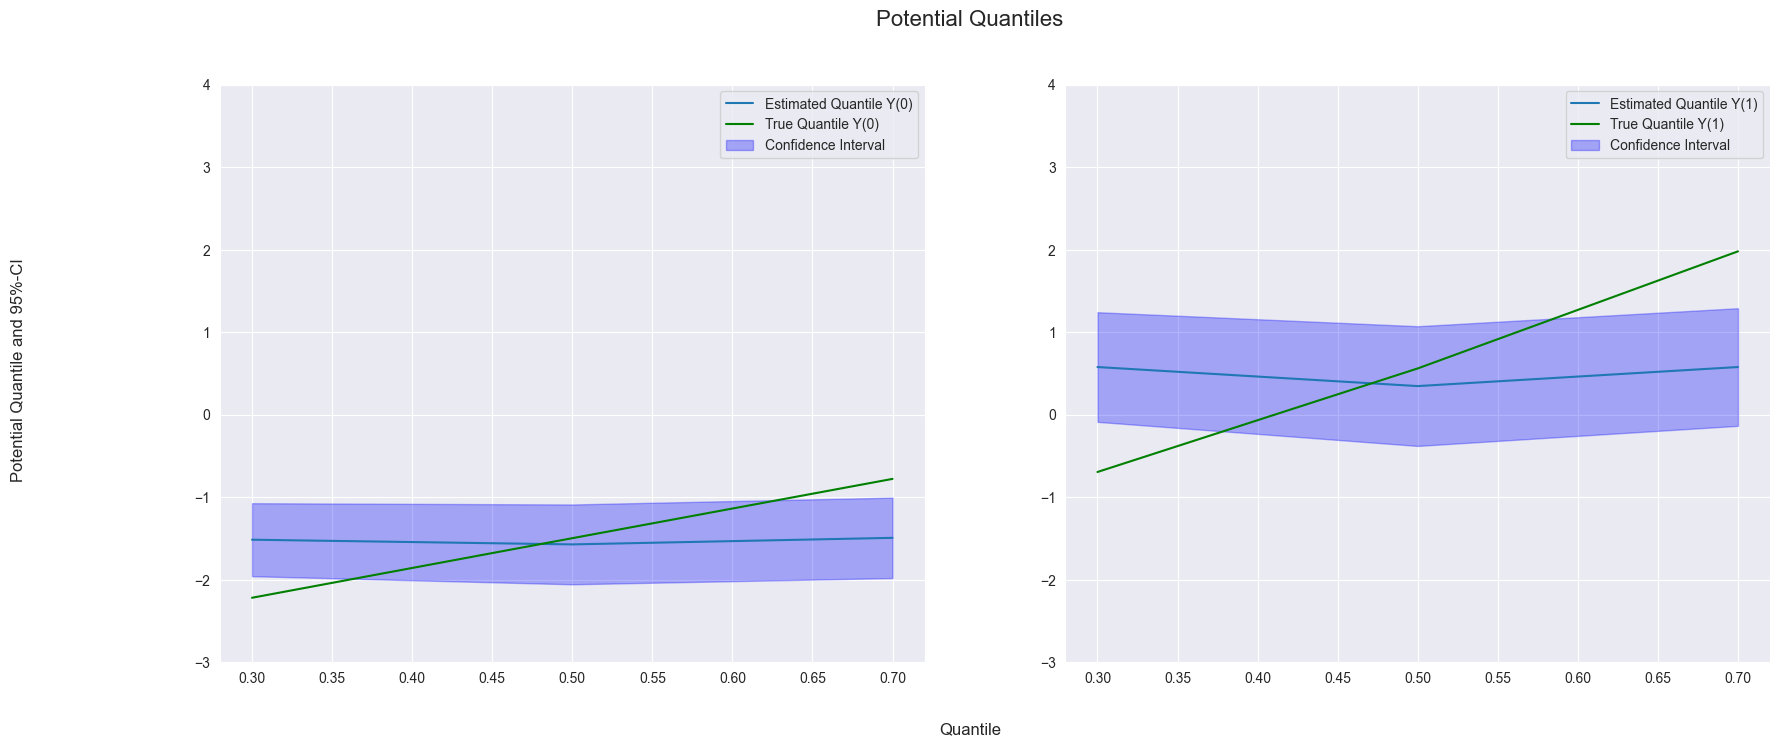

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)

ax1.plot(df['Quantile'],df['DML Y(0)'], label='Estimated Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color="green", label='True Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='b', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], label='Estimated Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color="green", label='True Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='b', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
fig.supylabel('Potential Quantile and 95%-CI')

To estimate the quantile treatment effect